# Refine lattice parameters on polycrystalline sample
This example shows how heterogeneous samples can be segmented automatically and how the segments can be processed independently.

It distinguishes sample regions with different diffraction patterns by clustering frames based on a feature vector that is generated from the presence or absence of specific peaks. These regions are then analyzed separately using the "region of interest" (ROI) feature of LiberTEM. In the end, the regions are merged again for plotting.

Credit goes to Karina Ruzaeva for developing the blobfinder core functionality and introducing the concept of feature vectors and clustering based on them to our work.

Sample data courtesy of Ian MacLaren Ian.MacLaren@glasgow.ac.uk and Shane McCartan s.mccartan.1@research.gla.ac.uk, University of Glasgow

Sample preparation: David Hall and Ilkan Calisir

The dataset is from a solid solution ceramic of bismuth ferrite and barium titanate (ratio: 75%/25%) doped 3% Ti. Chemical segregation of the bismuth ferrite and barium titanate occurs in the formation of the core-shell type structure that you can see in the grain (barium titanate-shell, bismuth ferrite-core). The grain is orientated along the [110] direction as the extra spots that BFO produces at the 1/2 (111) positions are obvious in this orientation. Otherwise the diffraction patterns of BFO and BTO are too similar to distinguish easily.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
%matplotlib nbagg

In [3]:
import functools

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sklearn.feature_extraction
import sklearn.cluster

In [4]:
import libertem.api as lt
import libertem.udf
import libertem.udf.blobfinder as blb
import libertem.analysis.gridmatching as grm
import libertem.udf.logsum as logsum
import libertem.udf.stddev as stddev
# fullmatch requires hdbscan, which is an optional dependency
import libertem.analysis.fullmatch as fm
import libertem.masks as ltmasks
import libertem.utils as ut

# This is useful for debugging to run everything in
# the same process so that one can use a debugger
#from libertem.executor.inline import InlineJobExecutor

In [5]:
# ctx = lt.Context(executor=InlineJobExecutor())
ctx = lt.Context()

In [6]:
ds = ctx.load(
    'blo',
    path=r'/cachedata/users/weber/data/Glasgow/10 um 110.blo'
)

In [7]:
(y, x) = ds.shape.nav
(fy, fx) = ds.shape.sig

In [8]:
r = 1.5
search = 5

## Find the zero order peak

The zero order peak is usuall the most intense one in a sum image of all log-scaled frames since it appears in most frames with significant intensity.

In [9]:
ls = logsum.run_logsum(ctx, dataset=ds)['logsum'].data
zero_pattern = blb.patterns.BackgroundSubtraction(radius=r)
zero = blb.correlation.get_peaks(ls, match_pattern=zero_pattern, num_peaks=1)[0]

## Generate a feature vector
We create a standard deviation map to find positions where intensity varies with scan position. The intensity at these positions can serve as a fingerprint for each frame. This allows to drastically reduce the amount of data that is used for clustering.

In [10]:
# Standard deviation map, which highlights pixels that vary across the scan.
# These varying pixels can be used to construct feature vectors.
stddev_result = stddev.run_stddev(ctx, ds)

We choose a fairly large number of peaks since many strong peaks come from the same lattice and are strongly correlated. By increasing the number of peaks we capture weak peaks as well so that they are represented well in the feature vector.

The peaks on the standard deviation map have mostly the same shape as the reflections themselves, that means we can use the peak finder to get their positions.

In [11]:
# We choose a tight outer radius to find very close peaks in the crowded total stddev image
match_pattern = blb.patterns.BackgroundSubtraction(radius=r, search=search, radius_outer=2.5)
# Find peaks in the stddev frame
std_found_peaks = blb.correlation.get_peaks(sum_result=stddev_result['std'], match_pattern=match_pattern, num_peaks=300)

We visualize the positions on the standard deviation map.

<IPython.core.display.Javascript object>


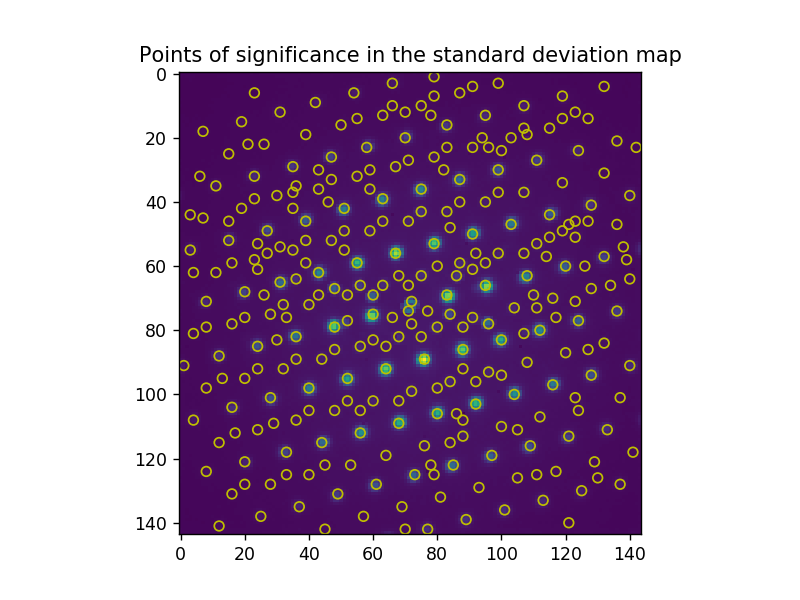

In [12]:
fig, axes = plt.subplots()
axes.imshow(stddev_result['std'])
plt.title("Points of significance in the standard deviation map")

for p in np.flip(std_found_peaks, axis=1):
    axes.add_artist(plt.Circle(p, r, color="y", fill=False))

Now we can use a mask UDF to generate the feature vector from the data. The `blobfinder` module provides the `feature_vector`method to generate a sparse mask stack that places a matching template on each peak position. Calculating the feature vector is a fast operation thanks to the optimized sparse mask back-end of LiberTEM.

In [13]:
stack = functools.partial(
    blb.utils.feature_vector,
    imageSizeX=fx,
    imageSizeY=fy,
    peaks=std_found_peaks,
    match_pattern=match_pattern,
)

feature_vec_udf = libertem.udf.masks.ApplyMasksUDF(
    mask_factories=stack,
    use_sparse=True,
    mask_count=len(std_found_peaks),
    mask_dtype=np.float32
)
%time feature_vecs_res = ctx.run_udf(dataset=ds, udf=feature_vec_udf)

CPU times: user 569 ms, sys: 144 ms, total: 713 ms
Wall time: 4.19 s


In [14]:
feature_vecs_res['intensity'].data.shape

(90, 121, 300)

 We scale each dimension by the mean absolute value to make sure that the presence or absence of weak peaks has the same impact as strong peaks.

In [15]:
feature_vecs = feature_vecs_res['intensity'].data
feature_vecs /= np.abs(feature_vecs).mean(axis=(0, 1))

We add x and y coordinate to the vector to include relative position information in the clustering. Spatially distant frames are more likely to belong to separate regions.

In [16]:
yy, xx = np.mgrid[0:y, 0:x] * 0.2
feature_vecs = np.concatenate((feature_vecs, yy[..., np.newaxis], xx[..., np.newaxis]), axis=2)

Visualization of a few selected feature vector dimensions. They are just virtual darkfield images.

<IPython.core.display.Javascript object>


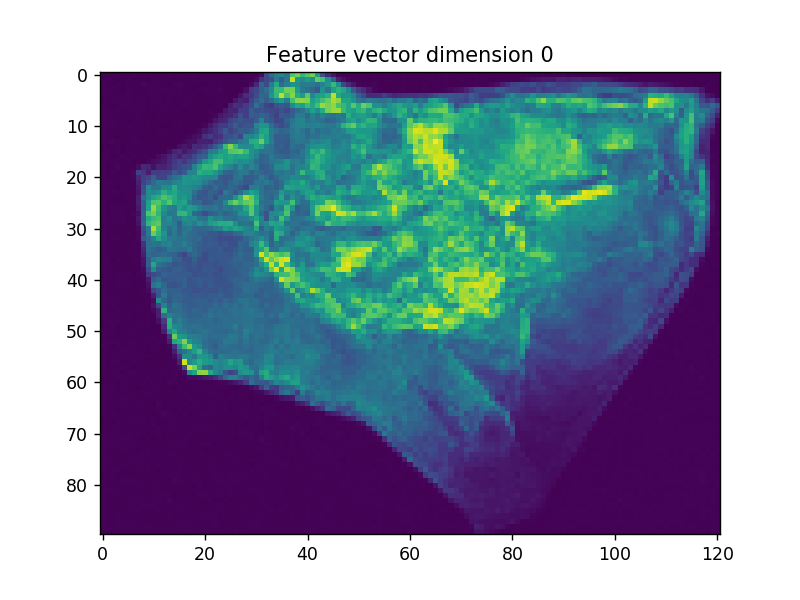

<IPython.core.display.Javascript object>


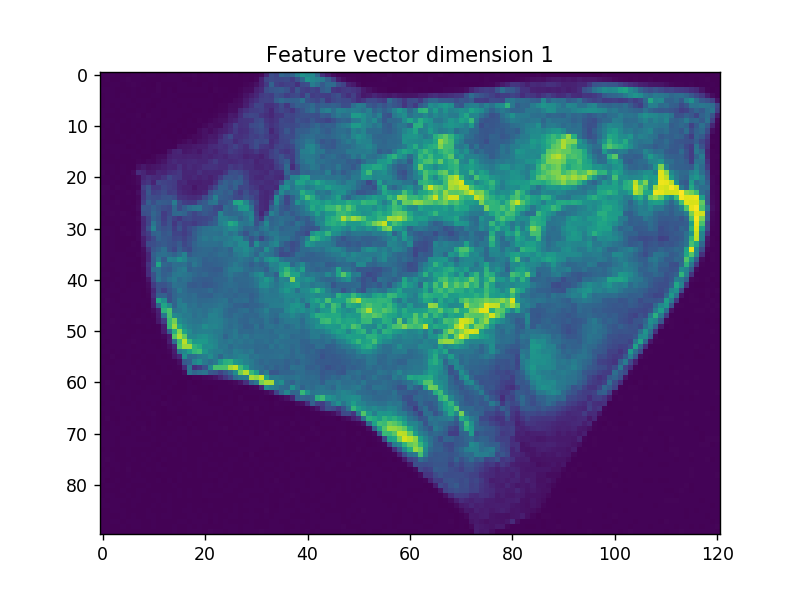

<IPython.core.display.Javascript object>


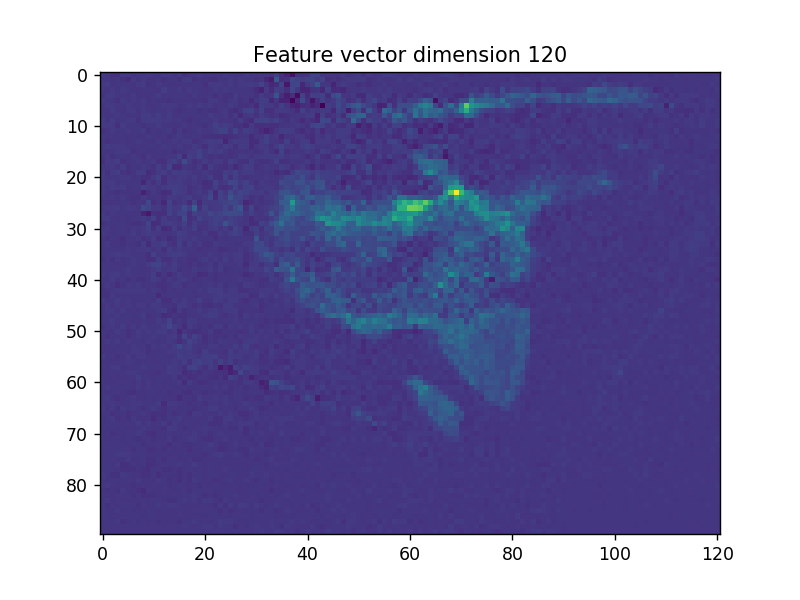

<IPython.core.display.Javascript object>


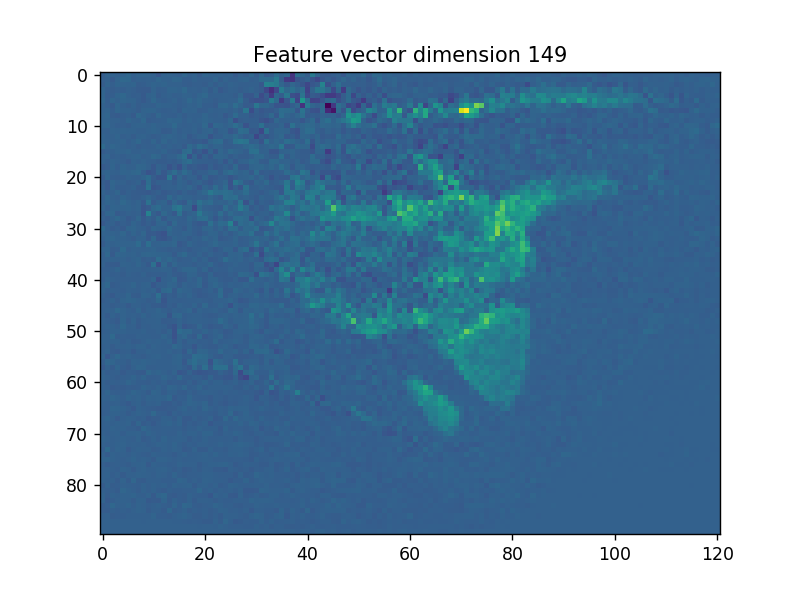

In [17]:
for i in (0, 1, 120, 149):
    fig, axes = plt.subplots()
    axes.imshow(feature_vecs[..., i])
    plt.title("Feature vector dimension %s" % i)

## Clustering
Now we can use the feature vector to cluster the frames in separate categories. Agglomerative clustering with a connectivity matrix for neighboring pixels generally works well.

In [18]:
connectivity = sklearn.feature_extraction.image.grid_to_graph(
    # Transposed!
    n_x=y,
    n_y=x
)

clusterer = sklearn.cluster.AgglomerativeClustering(
    affinity='euclidean',
    n_clusters=15,
    linkage='ward',
    connectivity=connectivity,
)

clusterer.fit(feature_vecs.reshape((y*x, -1)))

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=<10890x10890 sparse matrix of type '<class 'numpy.int64'>'
	with 54028 stored elements in COOrdinate format>,
                        distance_threshold=None, linkage='ward', memory=None,
                        n_clusters=15, pooling_func='deprecated')

In [19]:
labels = clusterer.labels_.reshape((y, x))

<IPython.core.display.Javascript object>


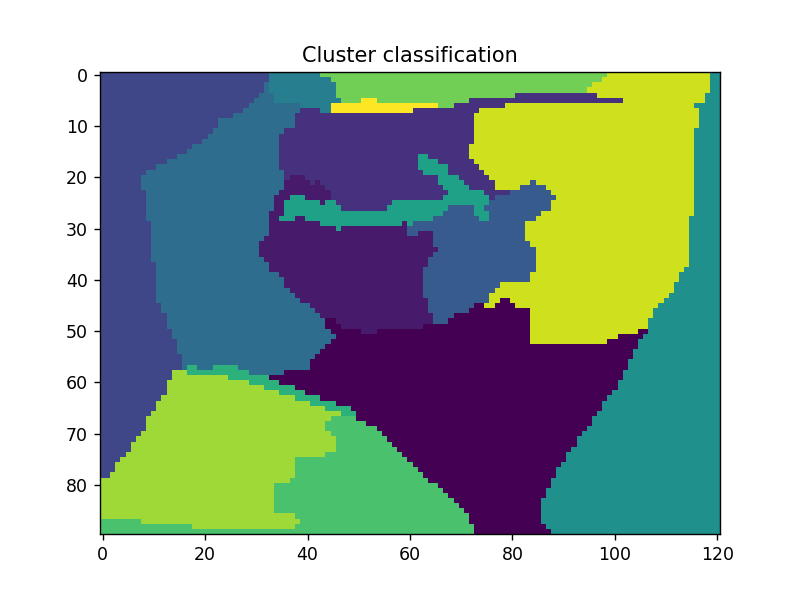

Text(0.5, 1.0, 'Cluster classification')

In [20]:
fig, axes = plt.subplots()
axes.imshow(labels)
plt.title("Cluster classification")

## Determine parameters individually for each cluster
Now we continue the processing by performing the strain mapping separately for each cluster. LiberTEM UDFs can use a region of interest, which is a boolean array of the same shape as the navigation dimension (scan dimension). It works analogously to fancy indexing for Numpy arrays: `True` values indicate frames that will be processed.

In [21]:
clusters = [dict() for i in range(np.max(labels))]

In [22]:
for i, d in enumerate(clusters):
    d['roi'] = (labels == i)
    d['logsum'] = logsum.run_logsum(ctx, dataset=ds, roi=d['roi'])['logsum'].data

We reduce the number of peaks to avoid finding many outliers or weak peaks. The tolerance should be adjusted for each dataset to get a good compromise between finding the "right" peaks and rejecting the "wrong" peaks. This depends on resolution, data quality and magnitude of the strain / deformation.

We pass the correct zero position to `libertem.analysis.fullmatch.FullMatcher.full_match` to have the same zero point in all clusters.

In [23]:
# Now we choose a wider outer radius because the sum frames of the clusters are less crowded than the stddev map
logframe_pattern = blb.BackgroundSubtraction(radius=r, radius_outer=4)

matcher = fm.FullMatcher()

for d in clusters:
    d['peaks'] = blb.get_peaks(sum_result=d['logsum'], match_pattern=logframe_pattern, num_peaks=20)
    d['fullmatch'] = matcher.full_match(d['peaks'], zero=zero)

We visualize the clusters in the scan dimension and the lattice match on their logsum frame. We paint all refined peak positions with a white circle, then paint the peaks that are part of the first match in red, and finally the position of peaks in a least square optimization of `zero`, `a` and `b` to best fit the matched peaks. Ideally, all these positions coincide.

<IPython.core.display.Javascript object>


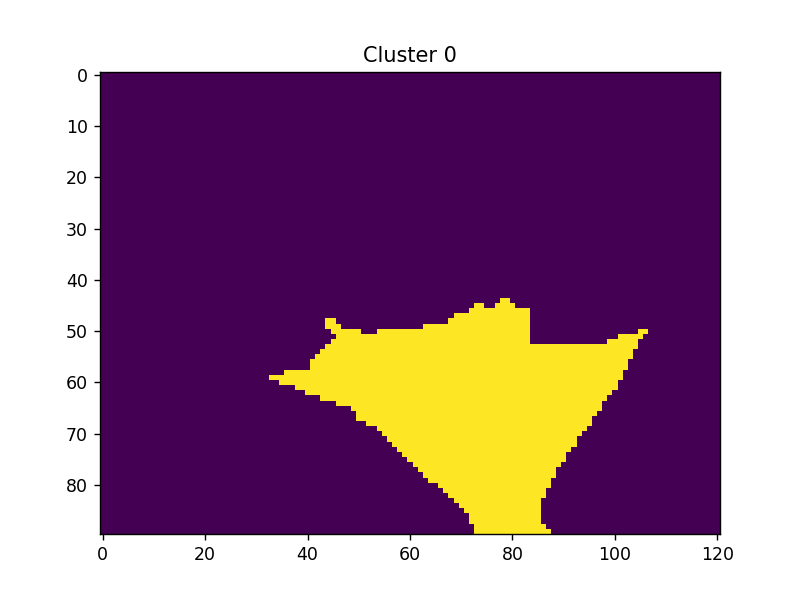

<IPython.core.display.Javascript object>


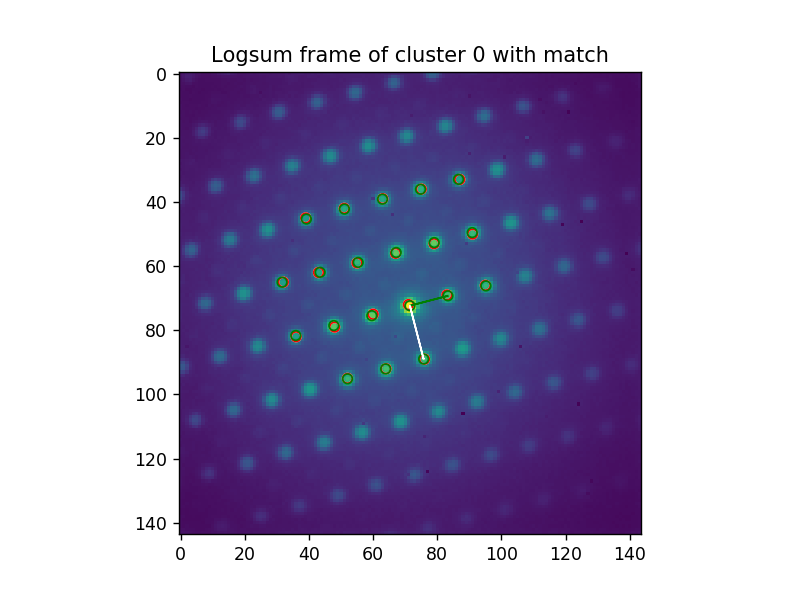

<IPython.core.display.Javascript object>


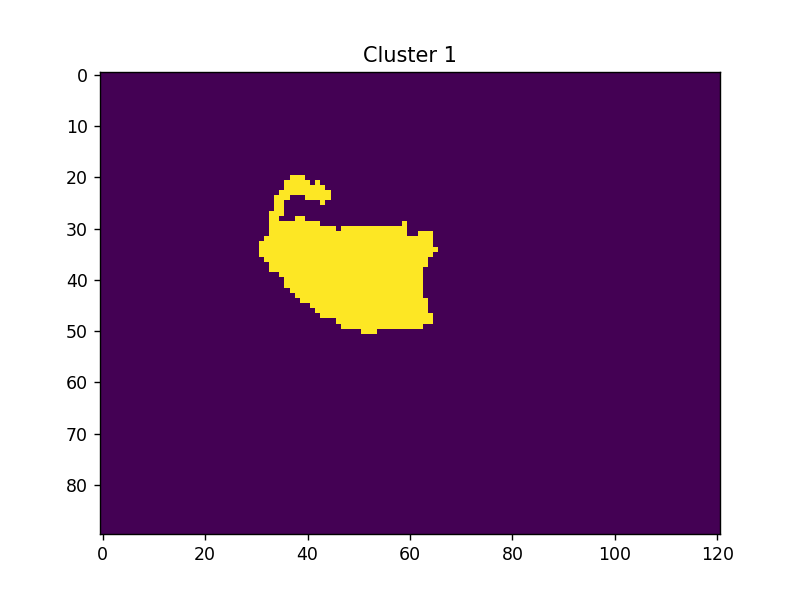

<IPython.core.display.Javascript object>


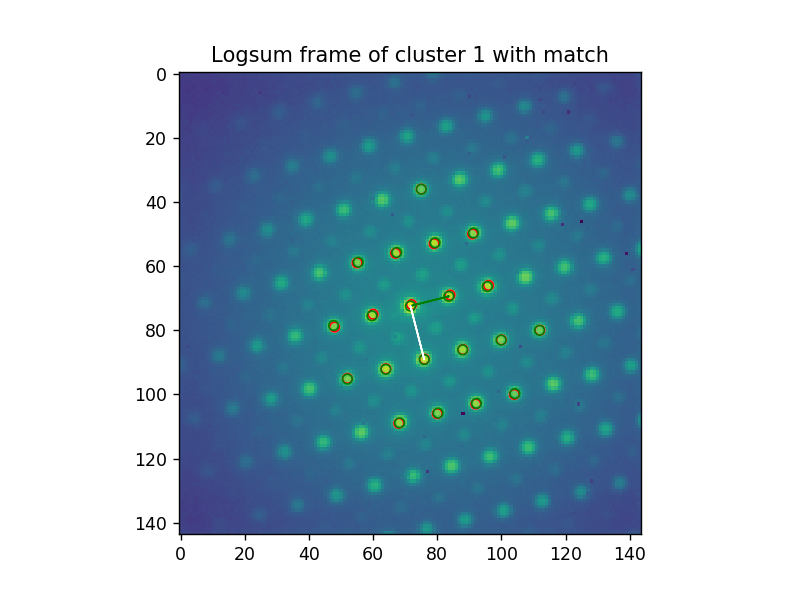

<IPython.core.display.Javascript object>


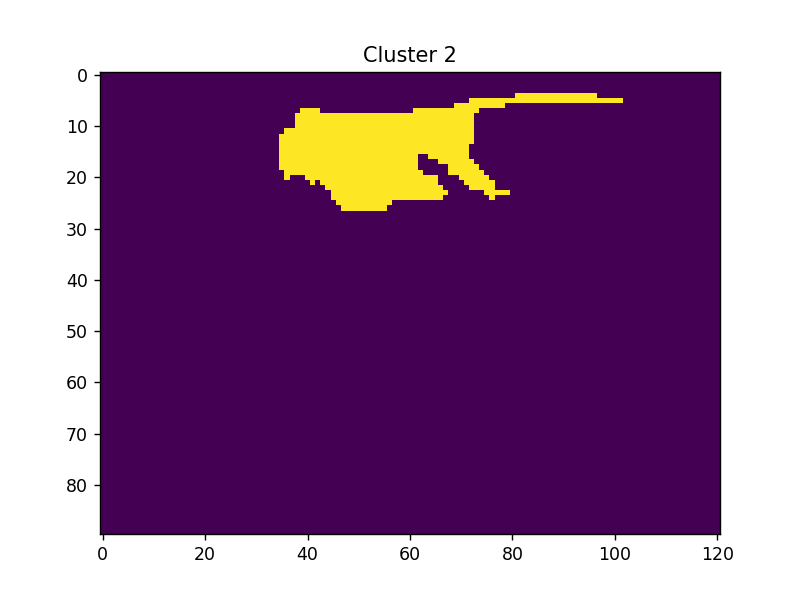

<IPython.core.display.Javascript object>


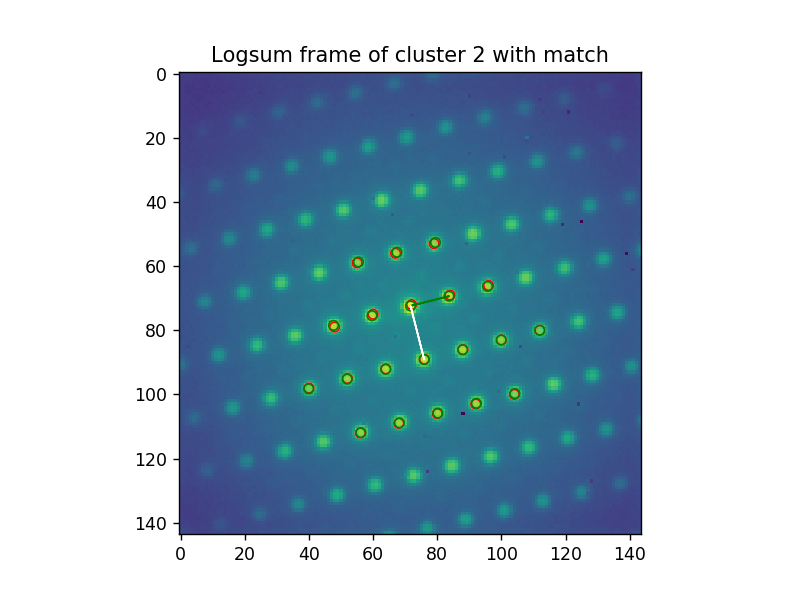

<IPython.core.display.Javascript object>


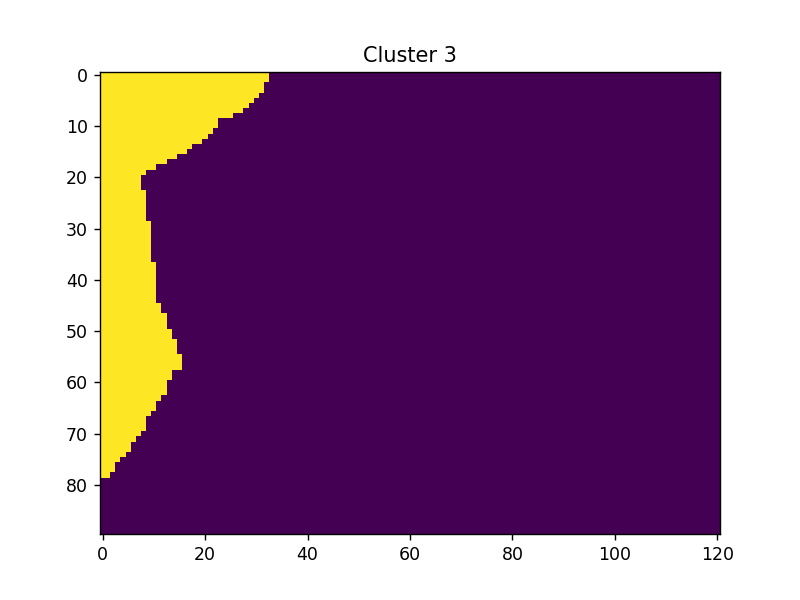

<IPython.core.display.Javascript object>


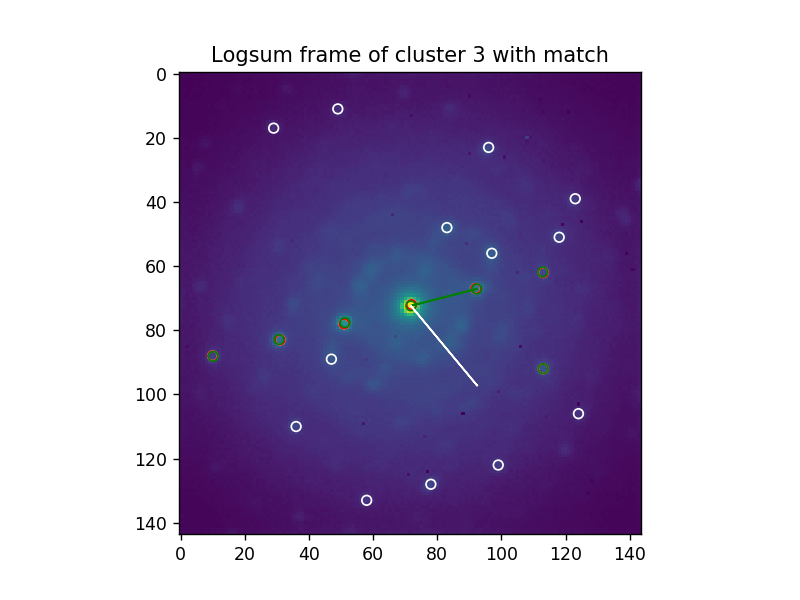

<IPython.core.display.Javascript object>


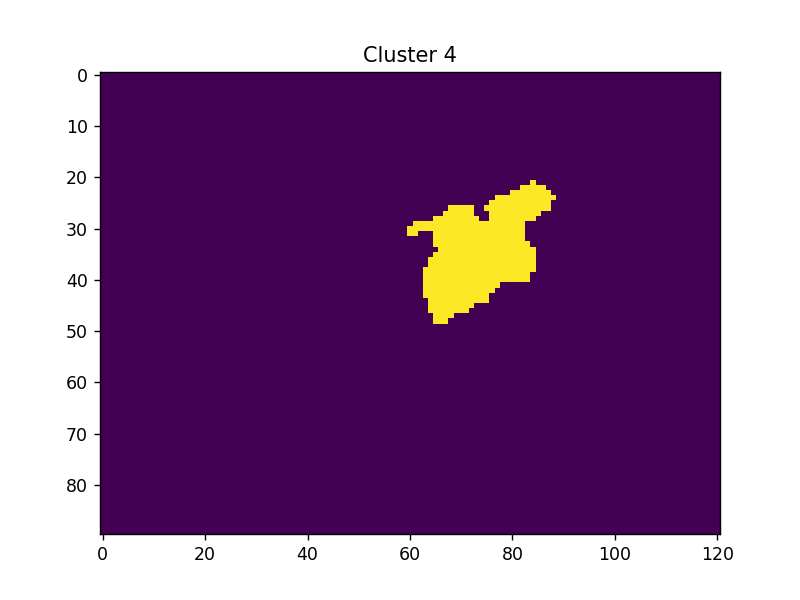

<IPython.core.display.Javascript object>


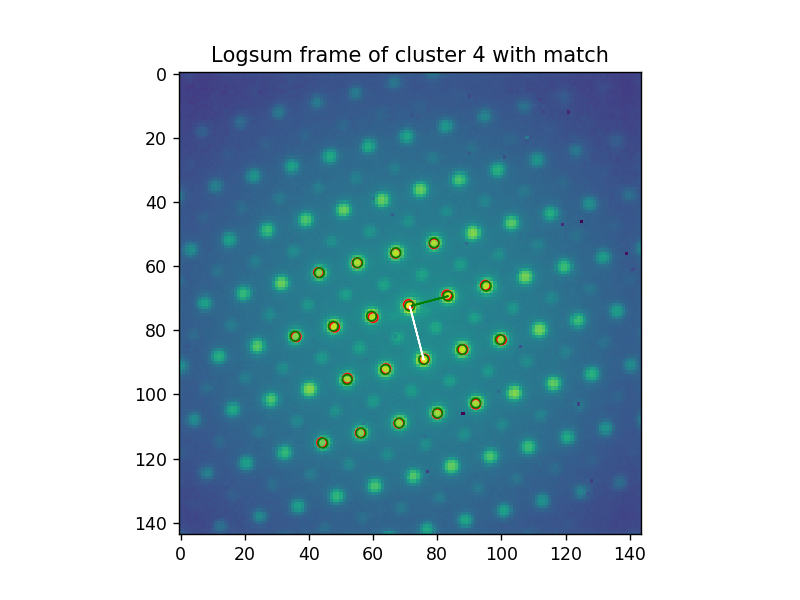

<IPython.core.display.Javascript object>


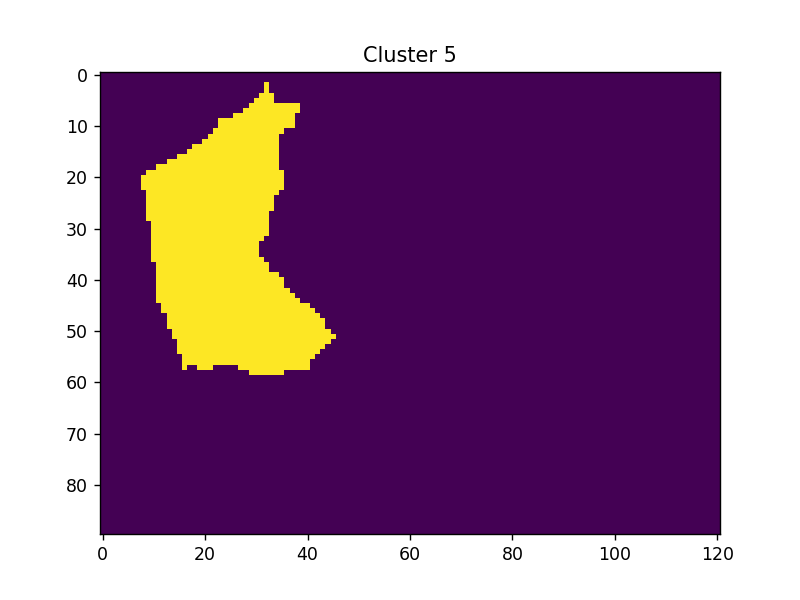

<IPython.core.display.Javascript object>


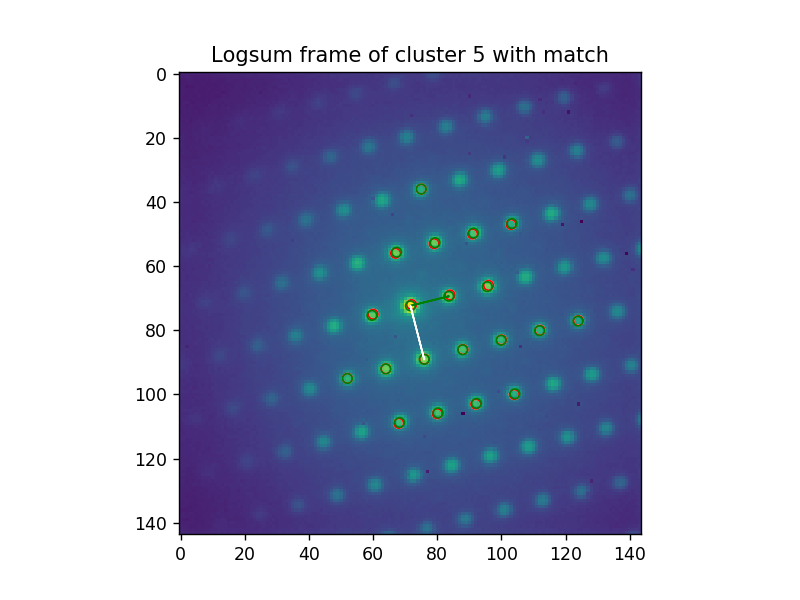

<IPython.core.display.Javascript object>


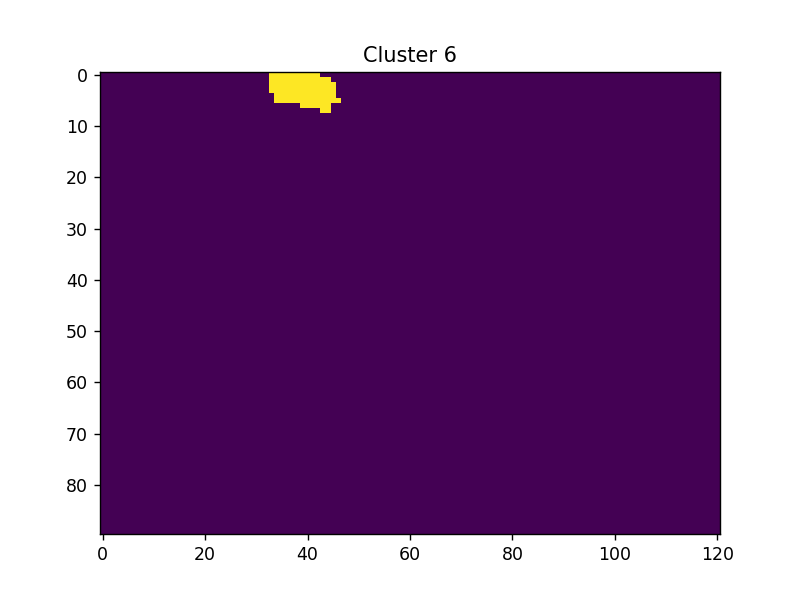

<IPython.core.display.Javascript object>


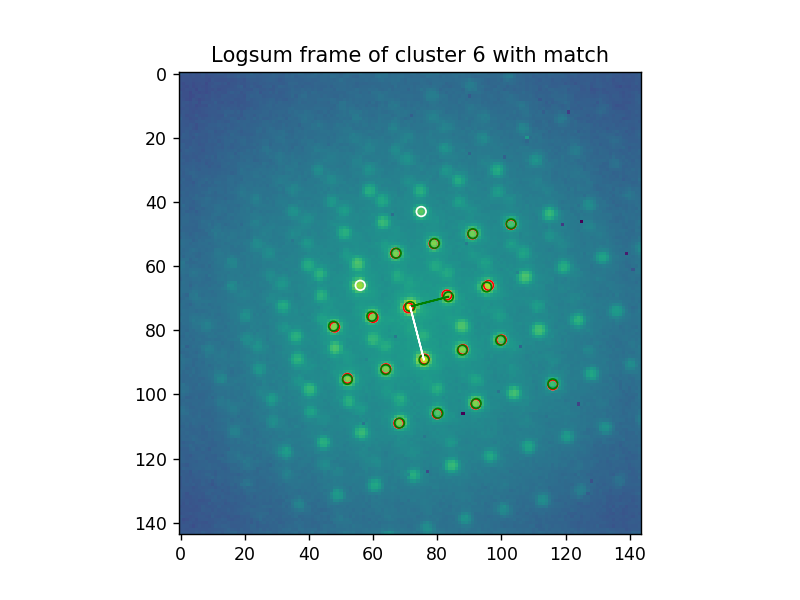

/cachedata/users/weber/libertem-uellue-venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


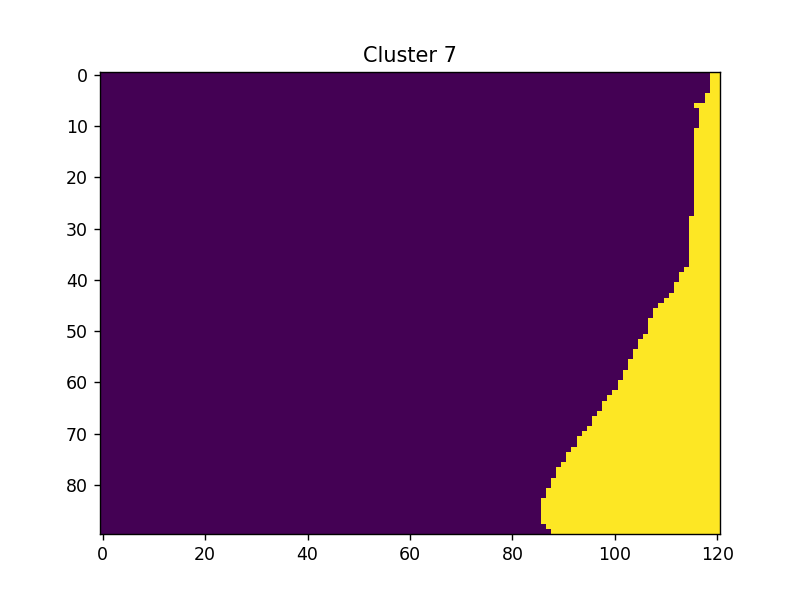

/cachedata/users/weber/libertem-uellue-venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


<IPython.core.display.Javascript object>


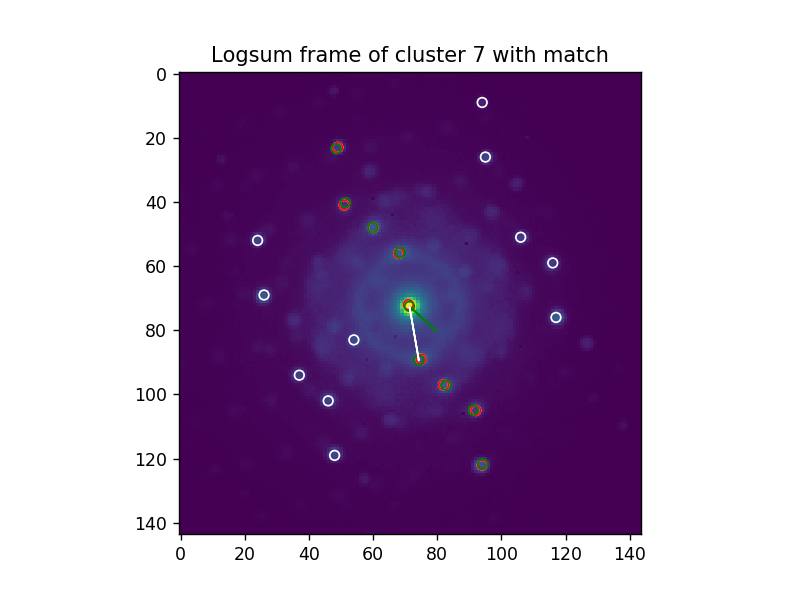

<IPython.core.display.Javascript object>


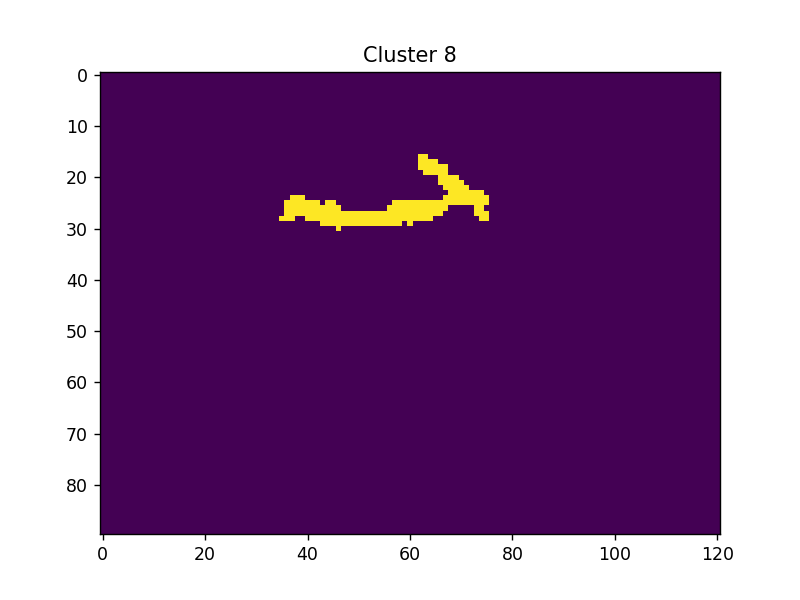

<IPython.core.display.Javascript object>


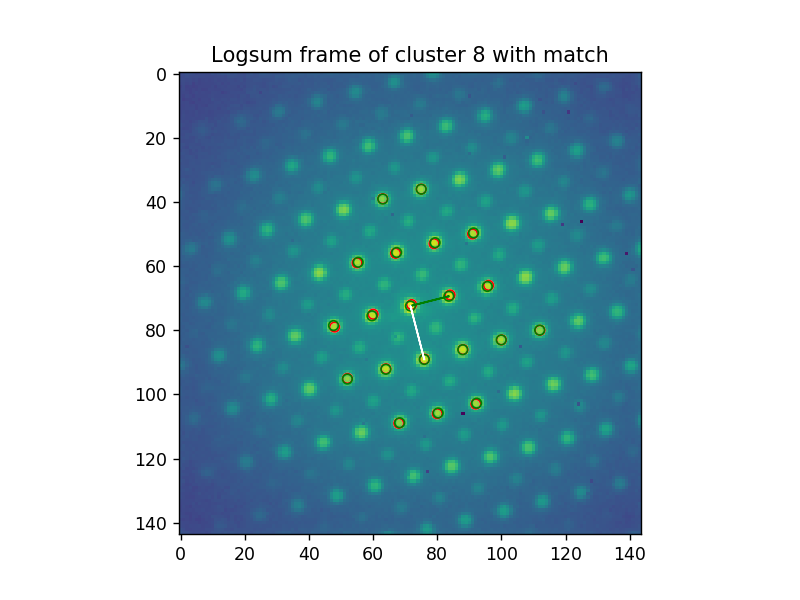

<IPython.core.display.Javascript object>


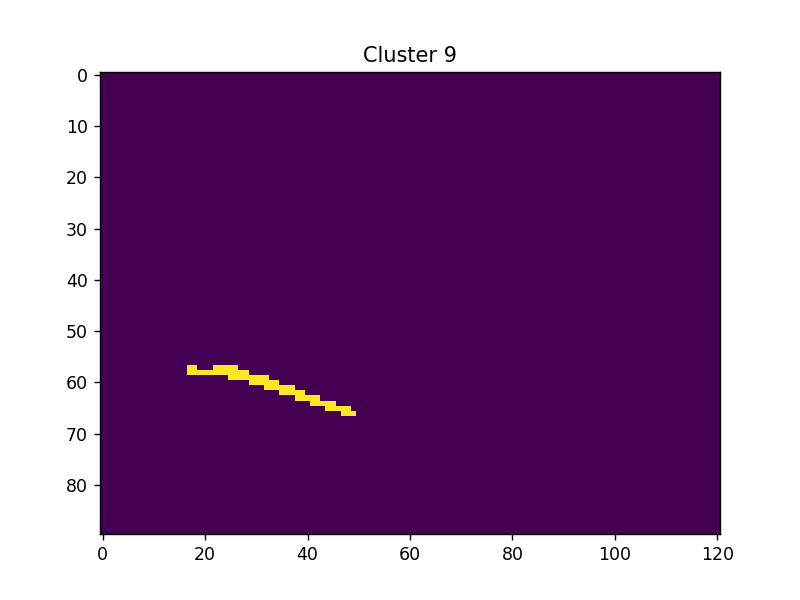

<IPython.core.display.Javascript object>


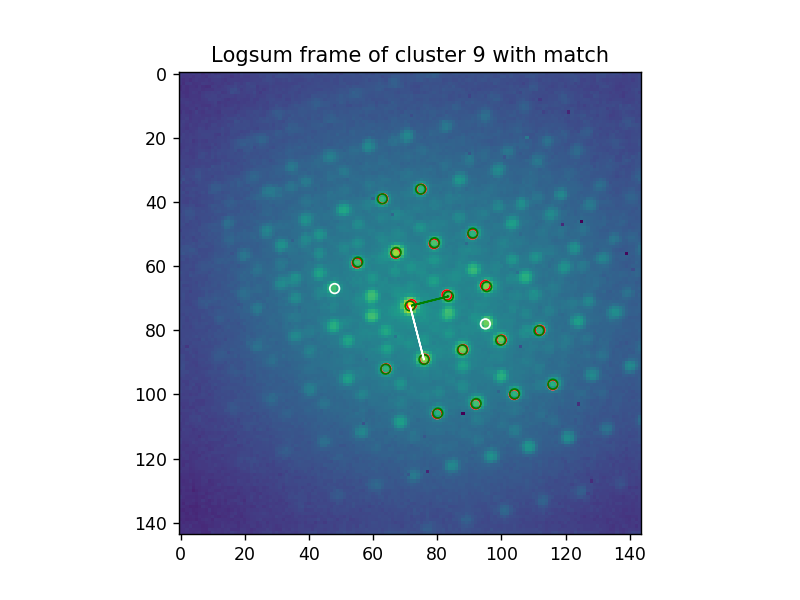

<IPython.core.display.Javascript object>


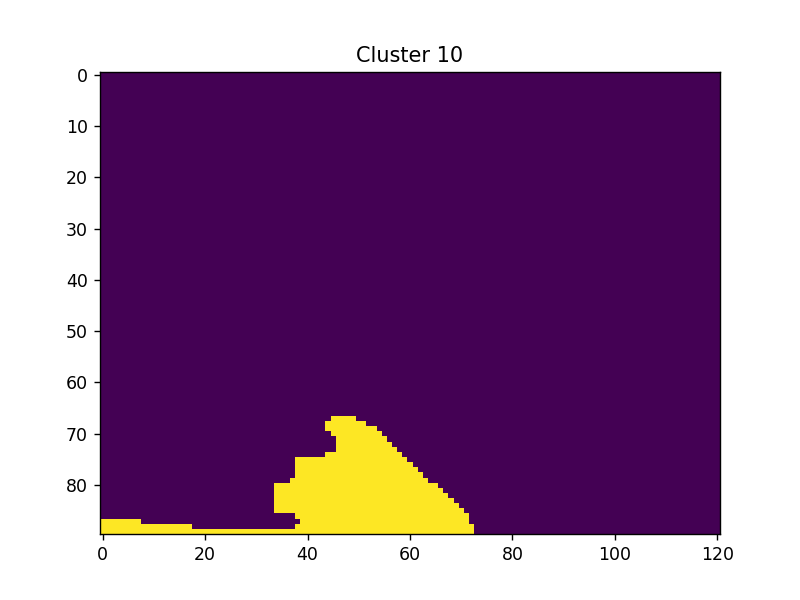

<IPython.core.display.Javascript object>


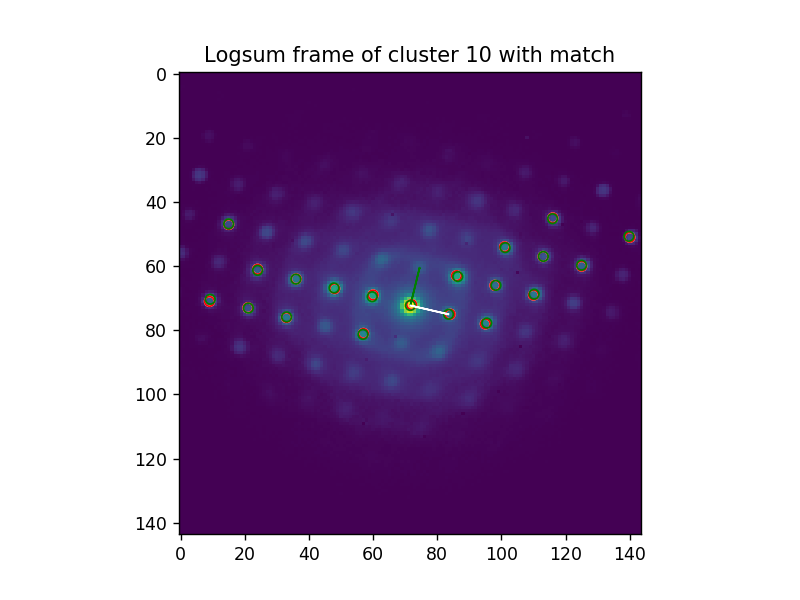

<IPython.core.display.Javascript object>


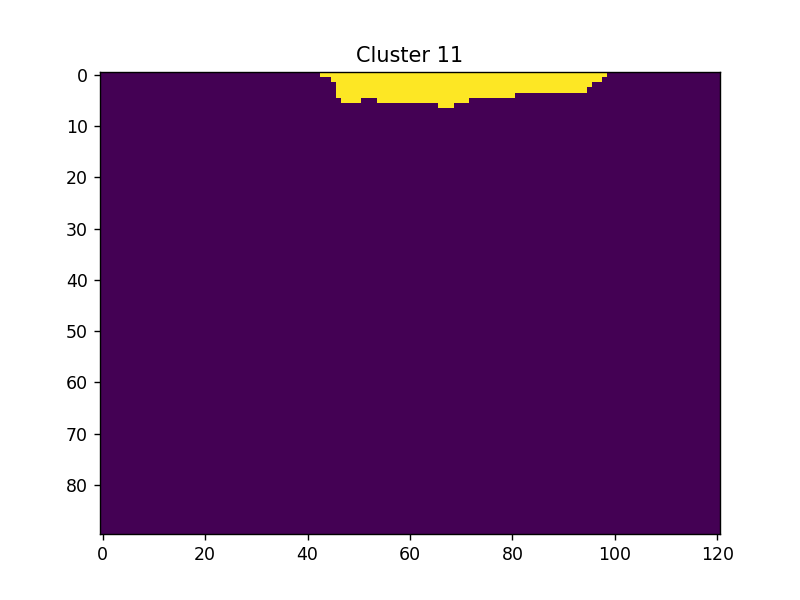

<IPython.core.display.Javascript object>


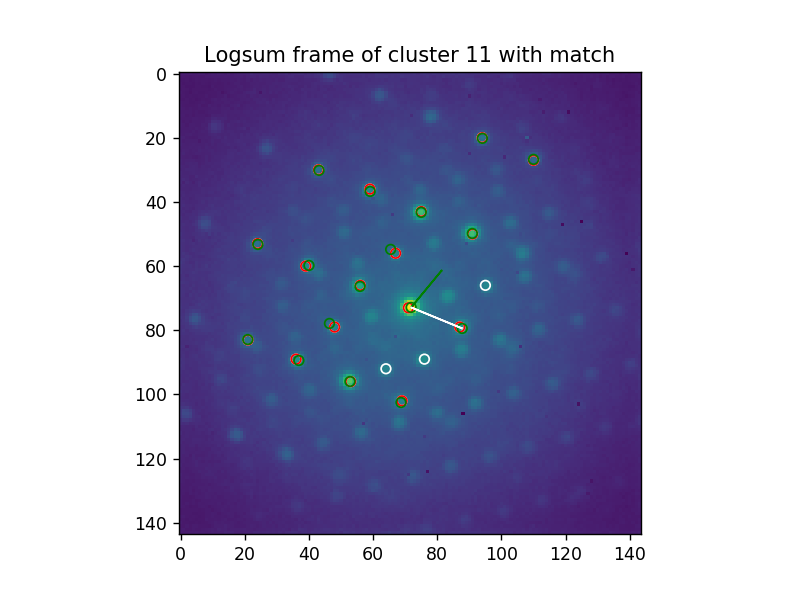

<IPython.core.display.Javascript object>


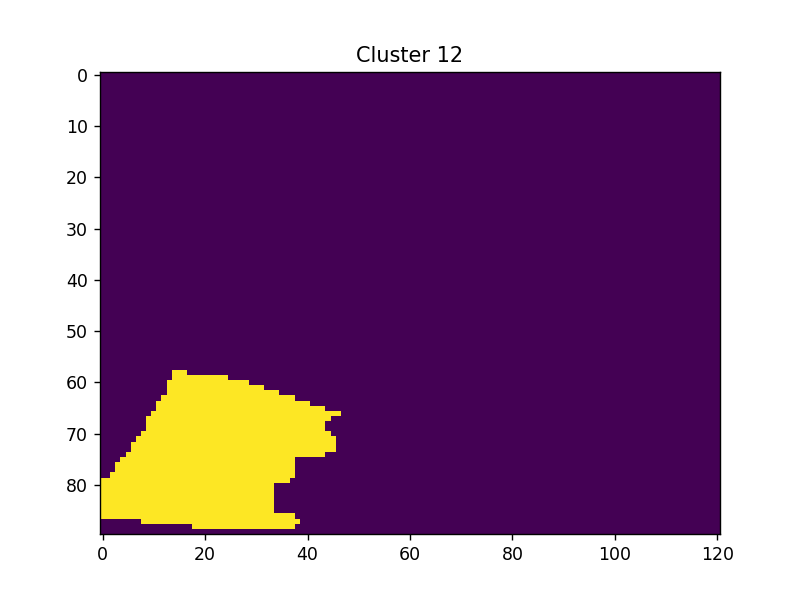

<IPython.core.display.Javascript object>


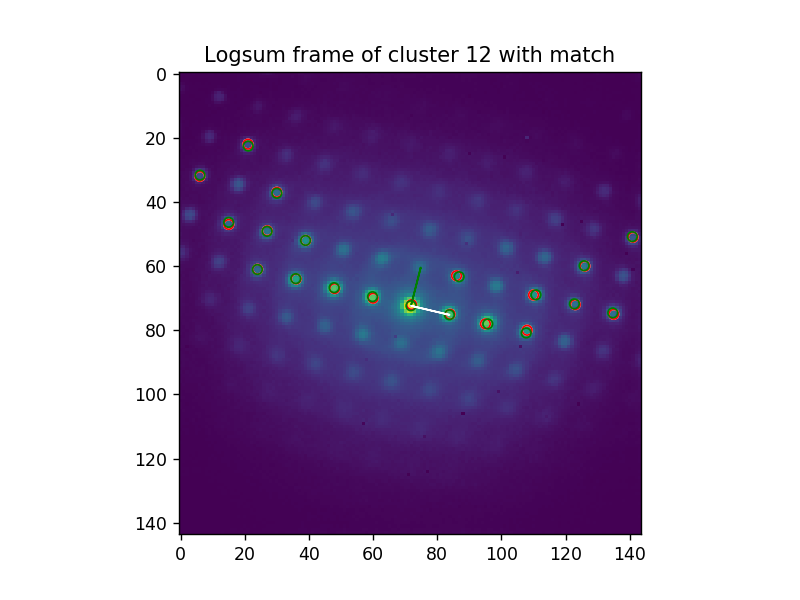

<IPython.core.display.Javascript object>


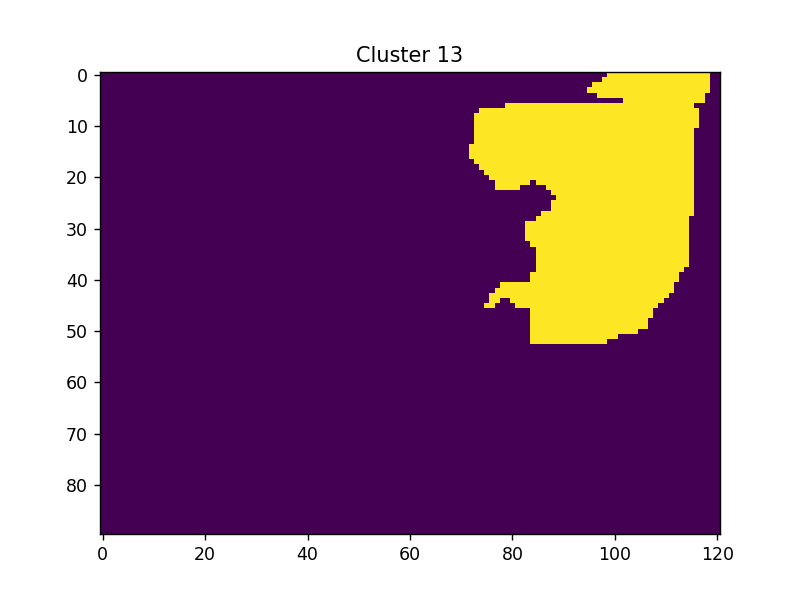

<IPython.core.display.Javascript object>


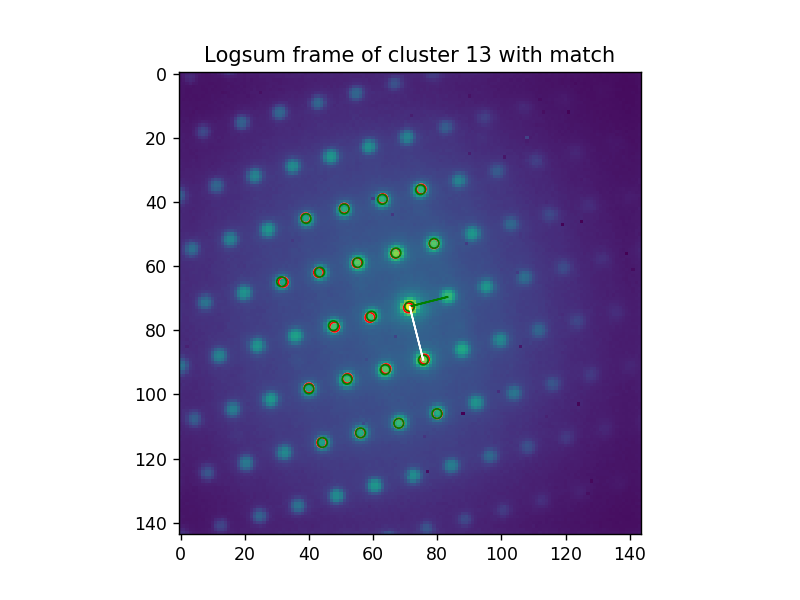

In [24]:
for i, d in enumerate(clusters):
    fig, axes = plt.subplots()
    axes.imshow(d['roi'])
    plt.title("Cluster %s" % i)
    fig, axes = plt.subplots()
    axes.imshow(d['logsum'])
    for p in np.flip(d['peaks'], axis=1):
        axes.add_artist(plt.Circle(p, r, color="w", fill=False))   
    m = d['fullmatch'][0][0]
    
    for p in np.flip(m.refineds, axis=1):
        axes.add_artist(plt.Circle(p, r, color="r", fill=False))
    for p in np.flip(m.calculated_refineds, axis=1):
        axes.add_artist(plt.Circle(p, r, color="g", fill=False))
    plt.arrow(*np.flip(m.zero), *(np.flip(m.a)), color='g')
    plt.arrow(*np.flip(m.zero), *(np.flip(m.b)), color='w')
    plt.title("Logsum frame of cluster %s with match" % i)

### Refine lattice parameters within each cluster

Now we can refine the lattice parameters for each frame within each cluster. This can be used to calculate a strain map.

In [25]:
for i, d in enumerate(clusters):
    print("Matching cluster %s of %s" % (i + 1, len(clusters)))
    m = d['fullmatch'][0][0]
    # Refine the lattice parameters for each frame
    (match, indices) = blb.run_refine(
        ctx=ctx,
        dataset=ds,
        zero=m.zero,
        a=m.a,
        b=m.b,
        matcher=matcher,
        match_pattern=logframe_pattern,
        roi=d['roi'],
        indices=np.mgrid[-4:5, -4:5]
    )
    d['match'] = match
    d['indices'] = indices

Matching cluster 1 of 14
Matching cluster 2 of 14
Matching cluster 3 of 14
Matching cluster 4 of 14
Matching cluster 5 of 14
Matching cluster 6 of 14
Matching cluster 7 of 14
Matching cluster 8 of 14
Matching cluster 9 of 14
Matching cluster 10 of 14
Matching cluster 11 of 14
Matching cluster 12 of 14
Matching cluster 13 of 14
Matching cluster 14 of 14


## Assembling the complete result
Fancy indexing allows us to combine the results from all clusters into one.

Note that we use `raw_data` instead of `data` because the latter contains a result for the entire navigation dimension padded with `nan` for results outside the cluster, while the former contains only the frames that are within the ROI.

In [26]:
zeros = np.zeros((y, x, 2), dtype=np.float32)
aas = zeros.copy()
bbs = zeros.copy()
for i, d in enumerate(clusters):
    zeros[d['roi']] = d['match']['zero'].raw_data
    aas[d['roi']] = d['match']['a'].raw_data
    bbs[d['roi']] = d['match']['b'].raw_data

In [27]:
polar_zeros = ut.make_polar(zeros)
polar_aas = ut.make_polar(aas)
polar_bbs = ut.make_polar(bbs)

The polar versions of the vectors are pairs of (length, angle) that make it easier to calculate size ratios and rotations.

In [28]:
polar_zeros.shape

(90, 121, 2)

Here we visualize the fit result for an individual frame. We figure out to which cluster the frame belongs and then use the appropriate data.

/cachedata/users/weber/libertem-uellue-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


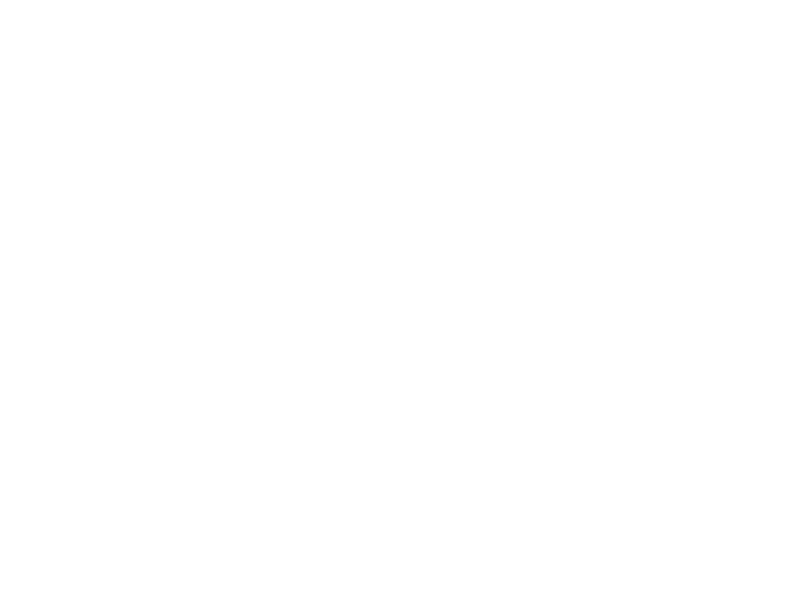

/cachedata/users/weber/LiberTEM-uellue/src/libertem/udf/blobfinder/utils.py:68: RuntimeWarning: divide by zero encountered in log
  pcm = axes.imshow(np.log(d - np.min(d) + 1))


Text(0.5, 1.0, 'Visualization of sample frame y=45, x=60, cluster=1')

In [29]:
fig, axes = plt.subplots()

yy, xx = y // 2, x // 2

cluster = labels[yy, xx]

blb.visualize_frame(
    ctx, ds,
    result=clusters[cluster]['match'],
    indices=clusters[cluster]['indices'],
    r=r,
    y=yy,
    x=xx,
    axes=axes
)

plt.title("Visualization of sample frame y=%s, x=%s, cluster=%s" % (yy, xx, cluster))


## Result visualization
For demonstration, a number of parameters are plotted. Adjusting the plot range reveals details within individual grains. Note how the central grain is uniform and smooth despite beging a composite of several clusters. That's because the matching code in `libertem.analysis.fullmatch.full_match` attempts to select grid vectors in a reproducible fashion, i.e. the same grid with different occupancy tends to result in the same grid vectors.

Please note that this example did not capture the superlattice in the central grain well. Since the superlattice peaks are weak compared to the main lattice, this would require manual adjustments of the feature vector positions and matching routines. This was omitted because this example is supposed to show the fully automated operation.

/cachedata/users/weber/libertem-uellue-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


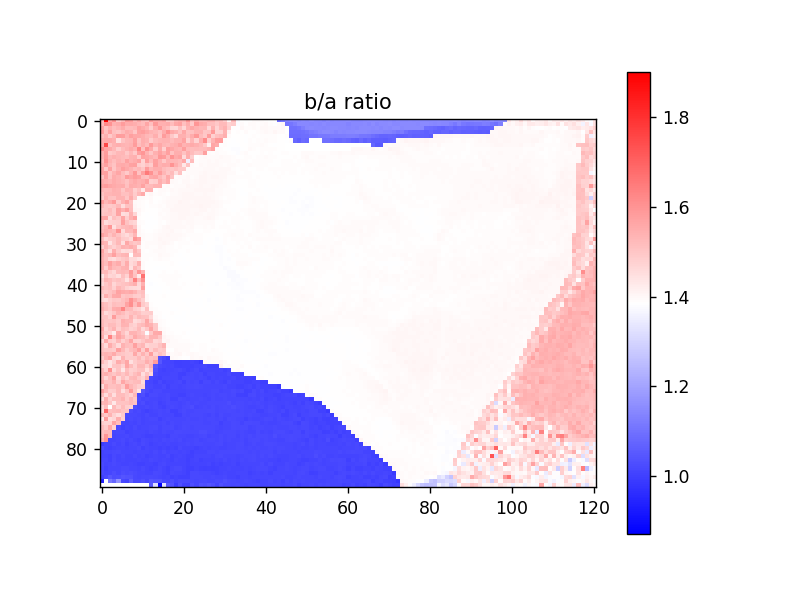

/cachedata/users/weber/libertem-uellue-venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
fig, axes = plt.subplots()
# maximum of a/b, b/a to extract "c/a" ratio
plt.imshow(polar_bbs[...,0] / polar_aas[...,0], cmap=cm.bwr)
plt.title("b/a ratio")
plt.colorbar()

/cachedata/users/weber/libertem-uellue-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


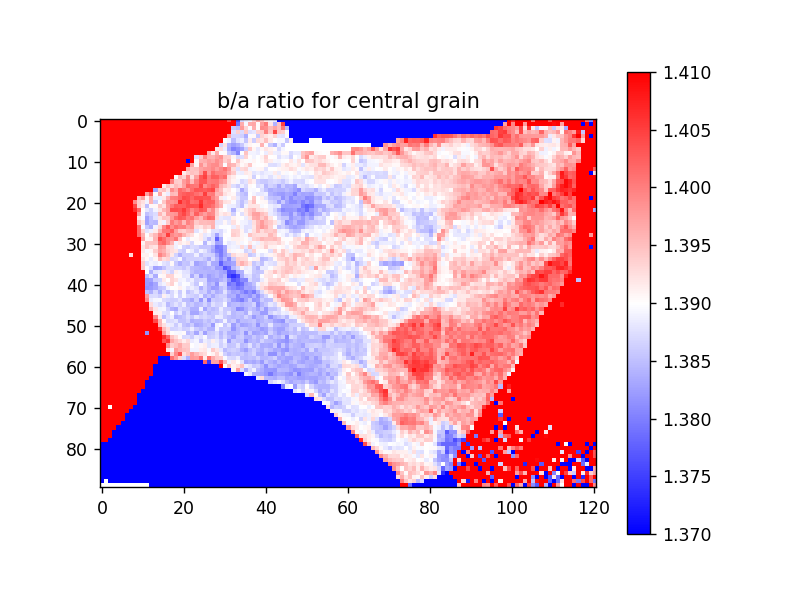

/cachedata/users/weber/libertem-uellue-venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [31]:
fig, axes = plt.subplots()
# maximum of a/b, b/a to extract "c/a" ratio
plt.imshow(
    polar_bbs[...,0] / polar_aas[...,0],
    cmap=cm.bwr,
    vmin=1.37,
    vmax=1.41,
)
plt.title("b/a ratio for central grain")
plt.colorbar()

/cachedata/users/weber/libertem-uellue-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


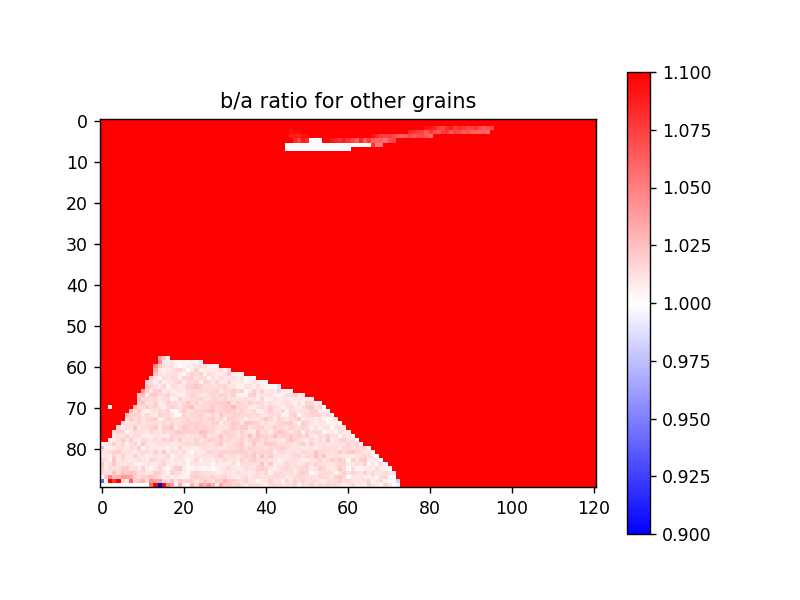

/cachedata/users/weber/libertem-uellue-venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [32]:
fig, axes = plt.subplots()
# maximum of a/b, b/a to extract "c/a" ratio
plt.imshow(
    polar_bbs[...,0] / polar_aas[...,0],
    cmap=cm.bwr,
    vmin=0.90,
    vmax=1.1,
)
plt.title("b/a ratio for other grains")
plt.colorbar()

/cachedata/users/weber/libertem-uellue-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


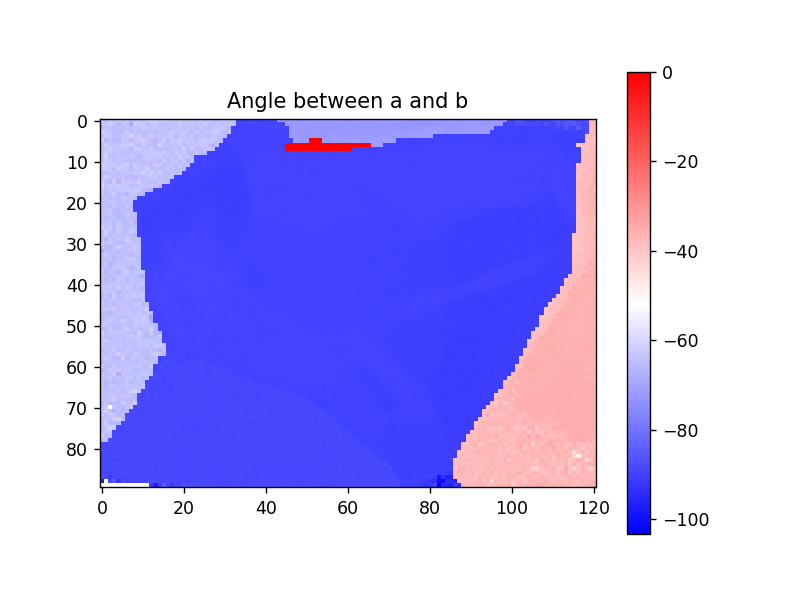

In [33]:
fig, axes = plt.subplots()
# Angle between a and b
plt.imshow((polar_aas[...,1] - polar_bbs[...,1])*180/np.pi, cmap=cm.bwr)
plt.title("Angle between a and b")
plt.colorbar()

/cachedata/users/weber/libertem-uellue-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


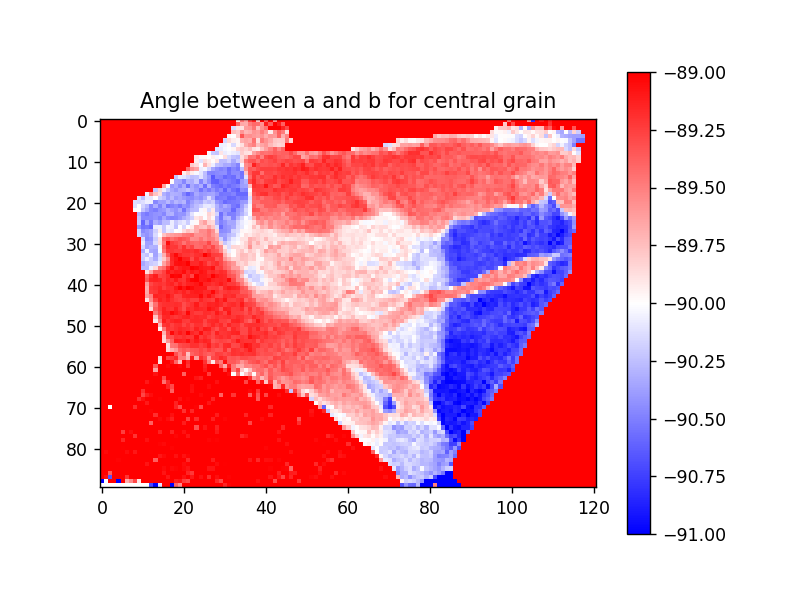

In [34]:
fig, axes = plt.subplots()
# Angle between a and b
plt.imshow((polar_aas[...,1] - polar_bbs[...,1])*180/np.pi, cmap=cm.bwr, vmin=-91, vmax=-89)
plt.title("Angle between a and b for central grain")
plt.colorbar()

/cachedata/users/weber/libertem-uellue-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


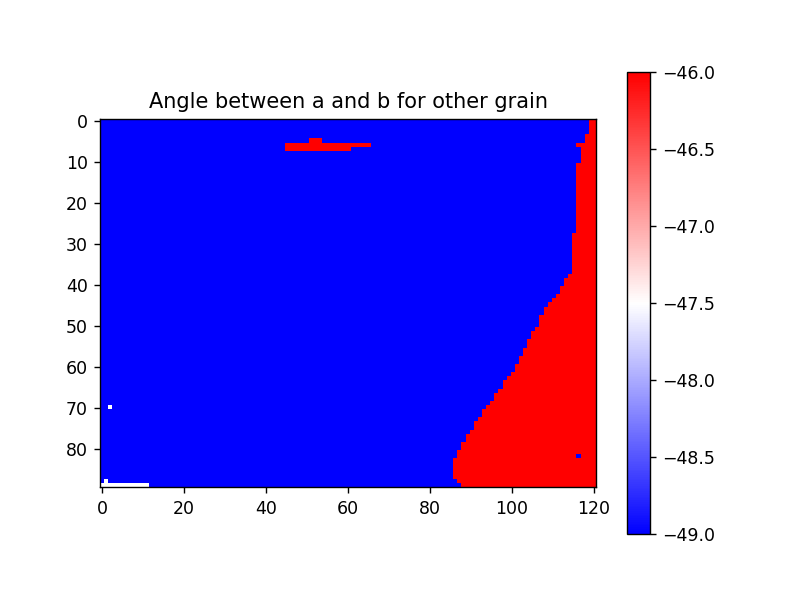

In [35]:
fig, axes = plt.subplots()
# Angle between a and b
plt.imshow((polar_aas[...,1] - polar_bbs[...,1])*180/np.pi, cmap=cm.bwr, vmin=-49, vmax=-46)
plt.title("Angle between a and b for other grain")
plt.colorbar()

/cachedata/users/weber/libertem-uellue-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


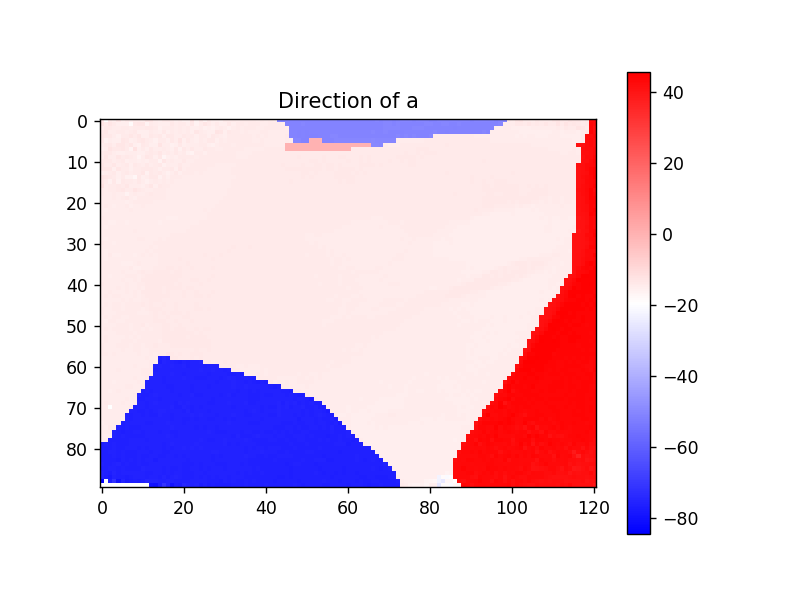

In [36]:
fig, axes = plt.subplots()
# Orientation of "a" vector
plt.imshow(polar_aas[...,1]*180/np.pi, cmap=cm.bwr)
plt.title("Direction of a")
plt.colorbar()

/cachedata/users/weber/libertem-uellue-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


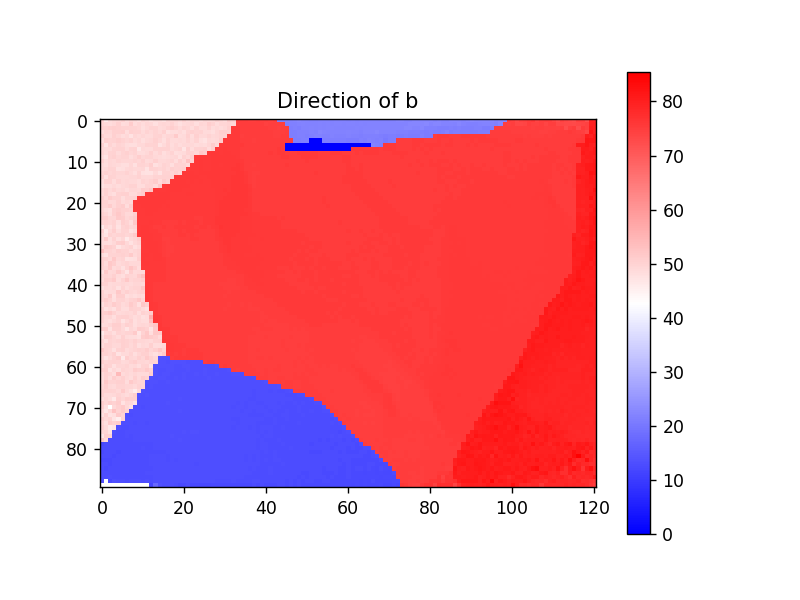

In [37]:
fig, axes = plt.subplots()
plt.imshow(polar_bbs[...,1]*180/np.pi, cmap=cm.bwr)
plt.title("Direction of b")
plt.colorbar()

/cachedata/users/weber/libertem-uellue-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


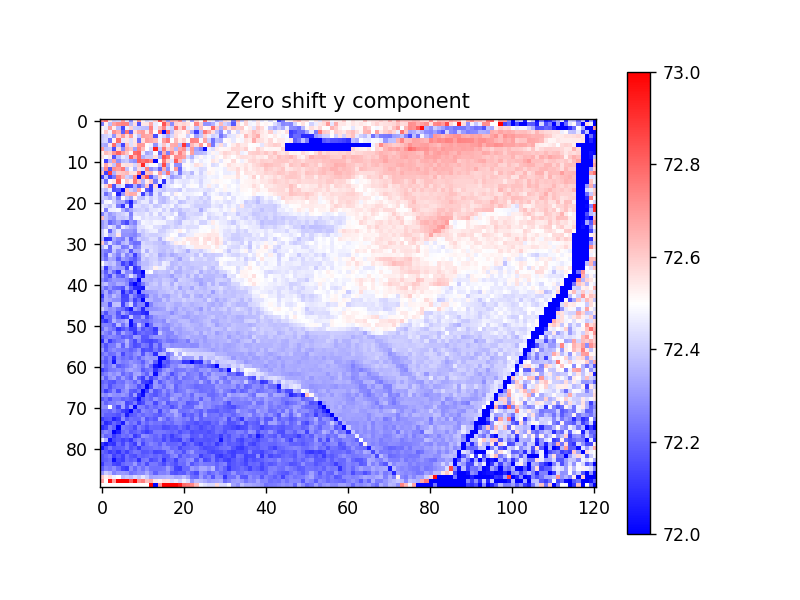

In [38]:
fig, axes = plt.subplots()
# Shift of the y component of the zero point
# Shifts of the zero point might reveal electromagnetic fields under some conditions.
plt.imshow(zeros[...,0], cmap=cm.bwr, vmin=72, vmax=73)
plt.title("Zero shift y component")
plt.colorbar()

/cachedata/users/weber/libertem-uellue-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


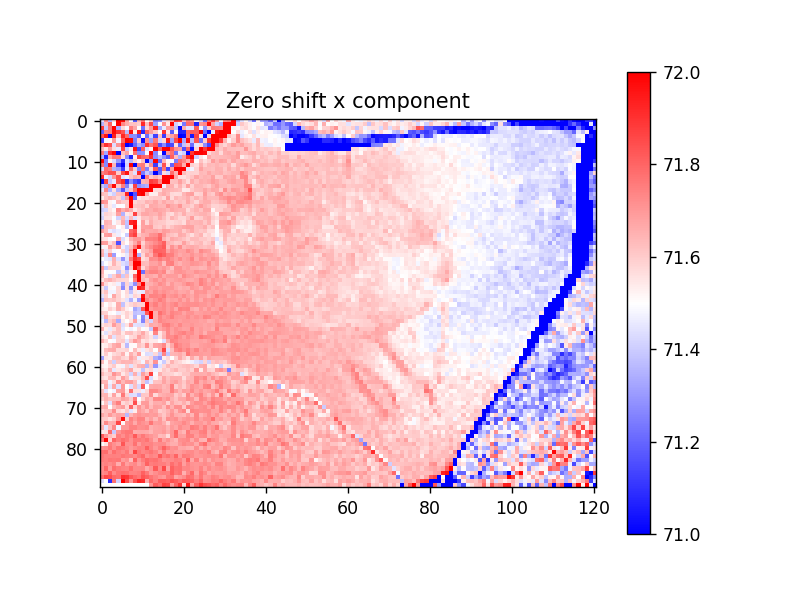

In [39]:
fig, axes = plt.subplots()
# Shift of the x component of the zero point
# Shifts of the zero point might reveal electromagnetic fields under some conditions.
plt.imshow(zeros[...,1], cmap=cm.bwr, vmin=71, vmax=72)
plt.title("Zero shift x component")
plt.colorbar()